# Time Series Analysis on Warner Bros Discovery Stock Price  

This is my first project with time series.

Notebook based on the Kaggle "Time Series" lessons: https://www.kaggle.com/learn/time-series

Dataset: https://finance.yahoo.com/quote/WBD/history?p=WBD  

Period: January 07 2022 - January 07 2023

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (15, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

import warnings
warnings.simplefilter(action='ignore')

In [2]:
import yfinance as yf
stock_symbol = 'WBD' ##change to any ticker of your choice
warner = yf.download(tickers = stock_symbol,period ='1y',interval ='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
# warner = pd.read_csv('./warner_bros.csv', parse_dates=['Date'], index_col='Date').drop(
#     columns=['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns={'Close':'Closing Price'})

# warner.info()

In [4]:
warner.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)

In [5]:
warner.rename(columns={'Close':'Closing Price'},inplace=True)

In [6]:
warner.index

DatetimeIndex(['2022-02-10', '2022-02-11', '2022-02-14', '2022-02-15',
               '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-22',
               '2022-02-23', '2022-02-24',
               ...
               '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02',
               '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08',
               '2023-02-09', '2023-02-10'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)

# Plotting the Data

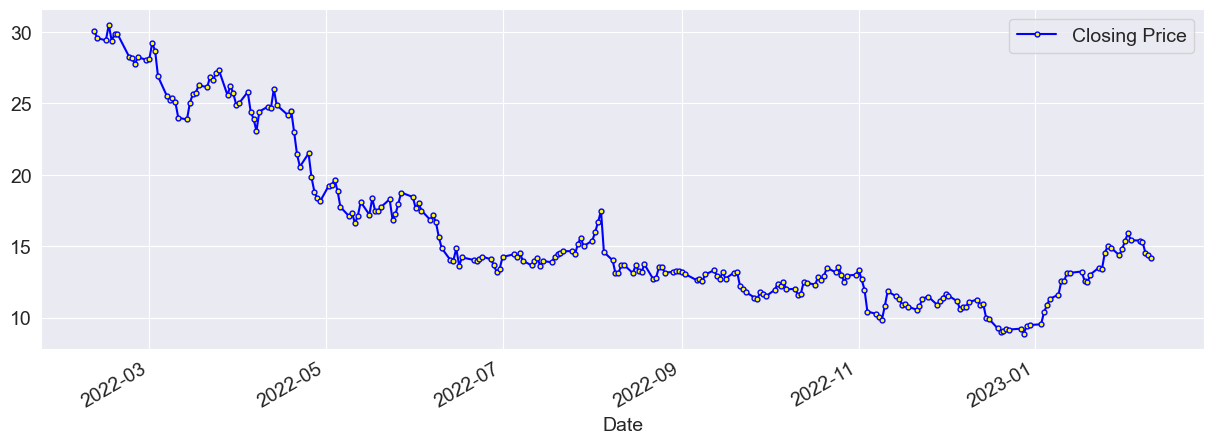

In [7]:
warner.plot(color='blue', marker='o', markersize=3.5, markerfacecolor='yellow');

# Trend  

Discovering the trend.

## Moving Average Plot Computation  

It does not seem to be a particular seasonality in the stocks' closing price.  
So, some different moving averages will be plotted to choose the smoothest one.  

Source: https://mins.space/blog/2020-06-29-moving-average-effect-window-size/

Creating a moving average function.

In [8]:
def moving_plotter(size, ax):
    # Creating the Moving Average
    mov_av = warner.rolling(
        window=size,
        center=True,
        min_periods=round(size/2)
    ).mean()
    mov_av['Trend'] = mov_av['Closing Price']
    mov_av.drop(columns='Closing Price', inplace=True)
    
    # Plotting it
    warner.plot(marker='o', color='grey', ax=ax)
    mov_av.plot(color='red', ax=ax);

Plotting different values.

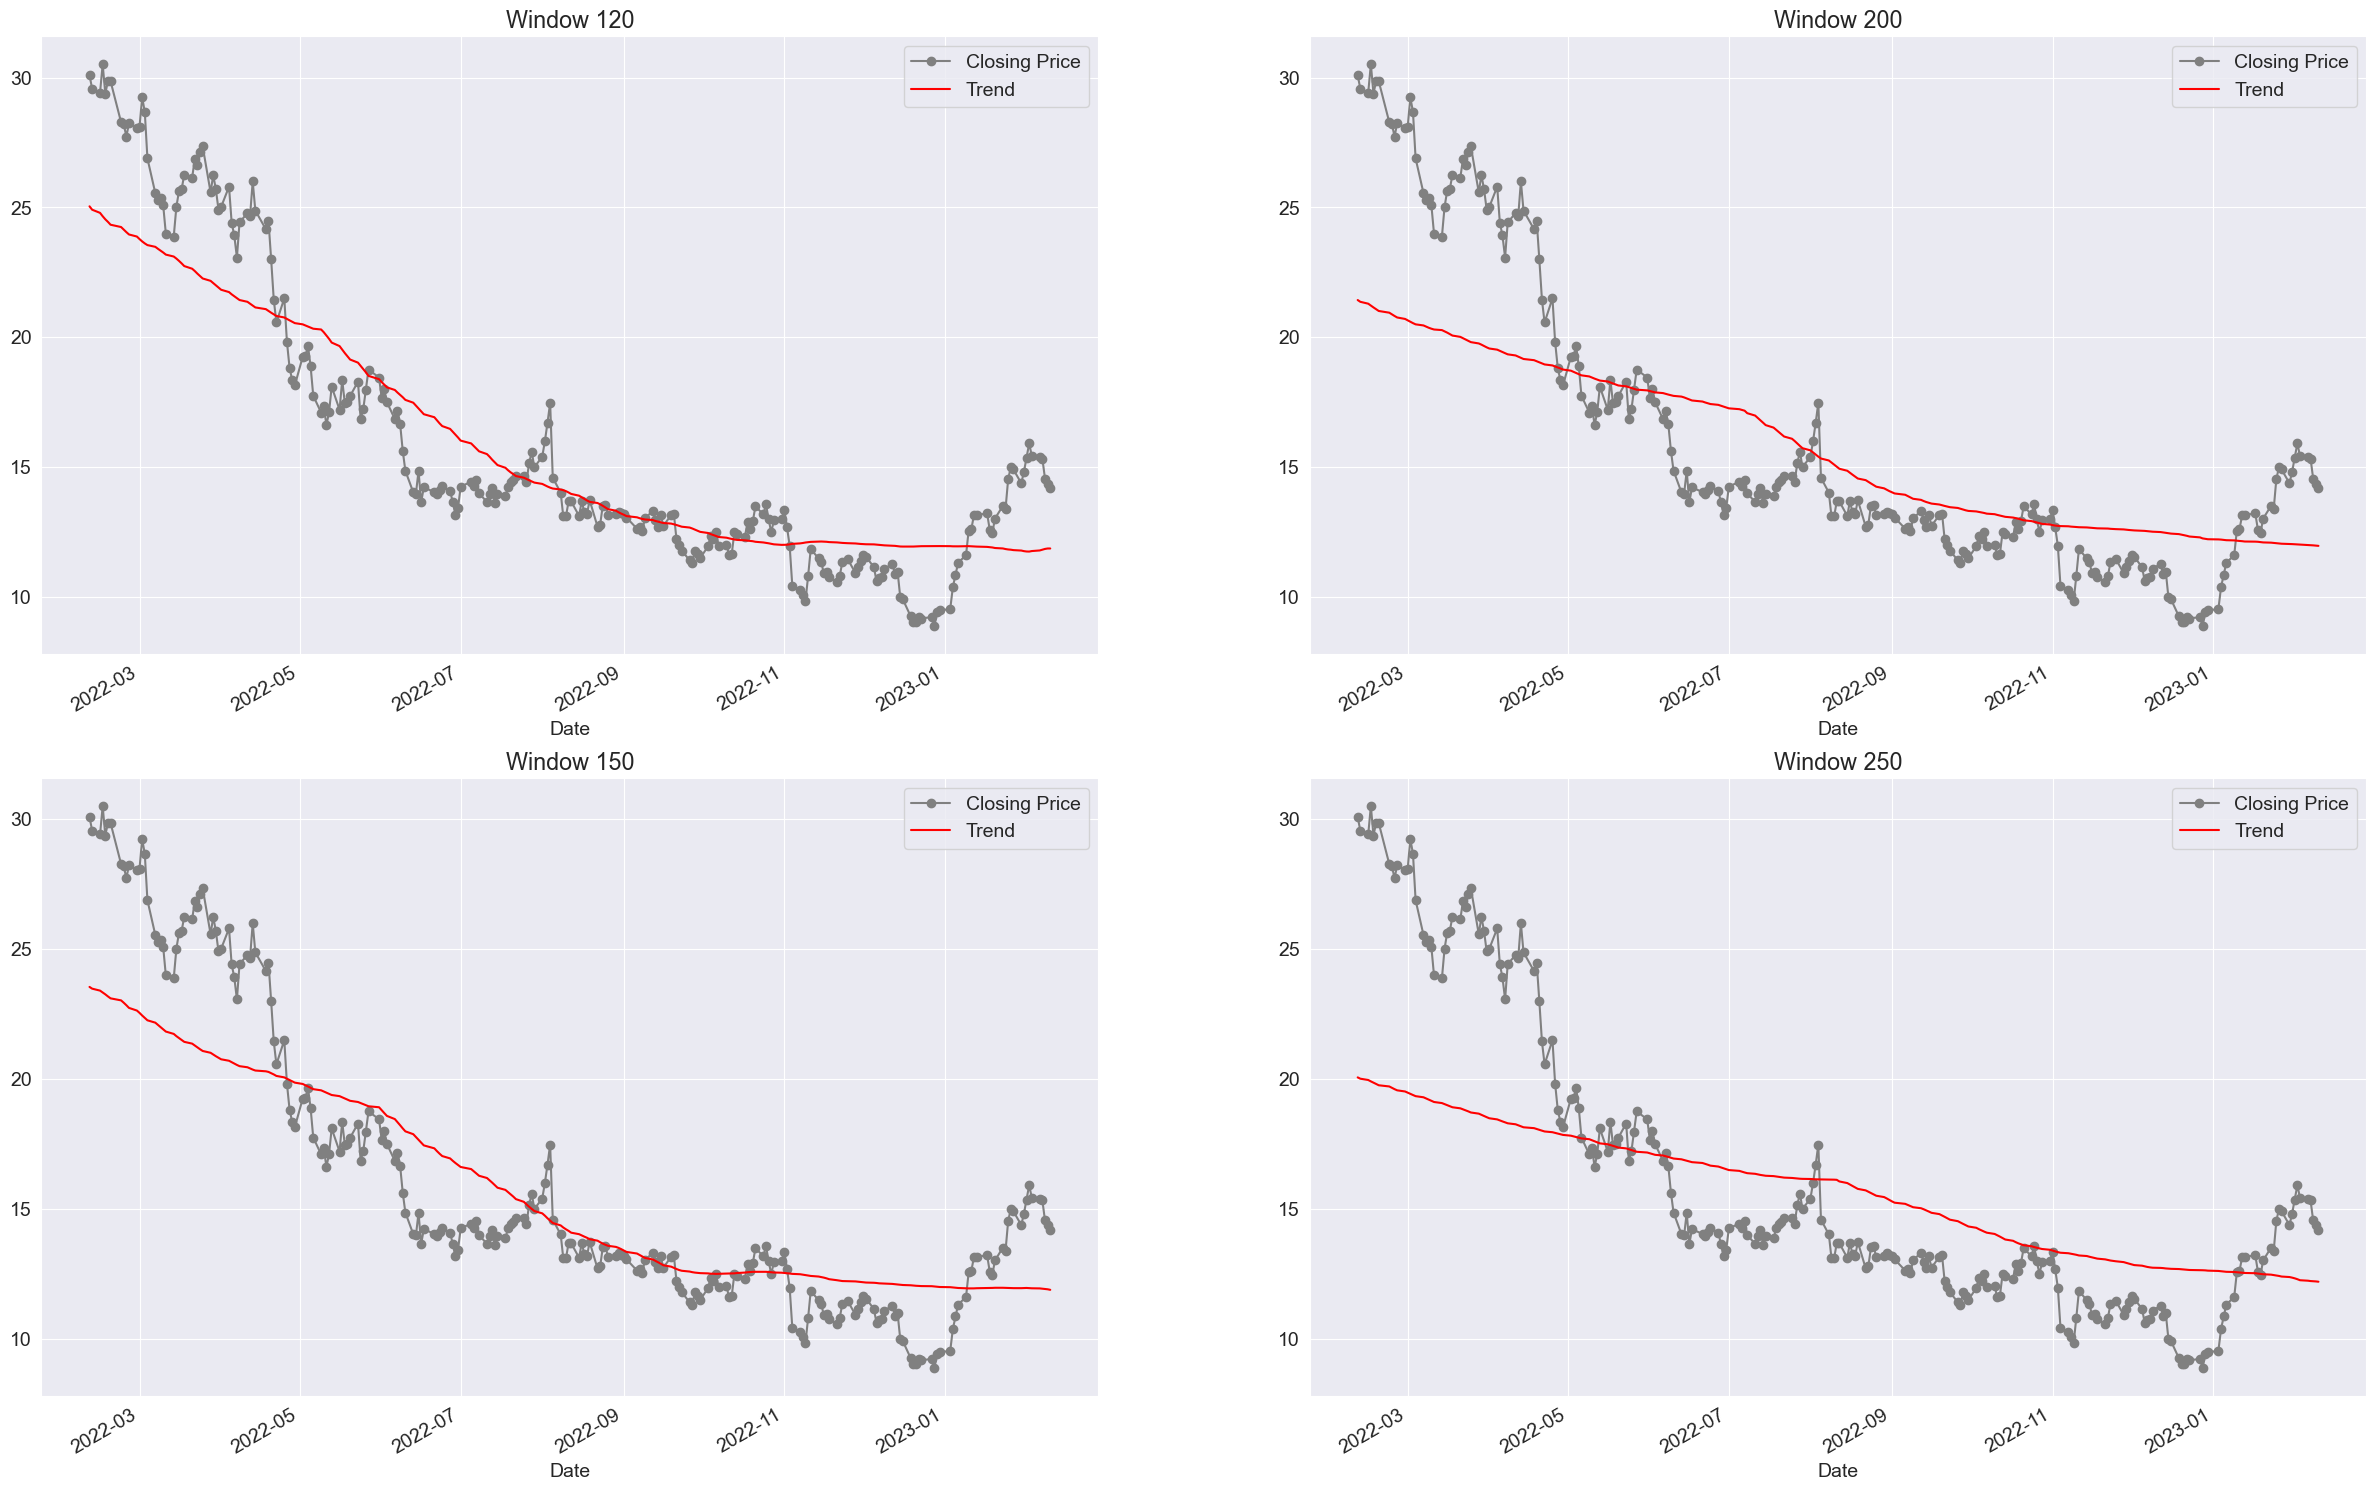

In [9]:
fig, axes = plt.subplots(2,2, figsize=(30,20))

axes[0,0].set_title('Window 120')
moving_plotter(120, axes[0,0])

axes[1,0].set_title('Window 150')
moving_plotter(150, ax=axes[1,0])

axes[0,1].set_title('Window 200')
moving_plotter(200, ax=axes[0,1])

axes[1,1].set_title('Window 250')
moving_plotter(250, ax=axes[1,1])

A 120 window seems to fit the trend well.

## Deterministic Process  

It will be used to make predictions about the trend and trying some forecasts.

In [10]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=warner.index,
    constant=True,
    order=2,
    drop=True
)

X = dp.in_sample()

In [11]:
X

,const,trend,trend_squared
Date,,,
2022-02-10,1.0,1.0,1.0
2022-02-11,1.0,2.0,4.0
2022-02-14,1.0,3.0,9.0
2022-02-15,1.0,4.0,16.0
2022-02-16,1.0,5.0,25.0
...,...,...,...
2023-02-06,1.0,248.0,61504.0
2023-02-07,1.0,249.0,62001.0
2023-02-08,1.0,250.0,62500.0


In [12]:
y = warner['Closing Price']

from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.DataFrame(model.predict(X), columns=['Trend'], index=X.index)

In [13]:
y_pred

,Trend
Date,
2022-02-10,30.194663
2022-02-11,29.986915
2022-02-14,29.780312
2022-02-15,29.574856
2022-02-16,29.370545
...,...
2023-02-06,13.697135
2023-02-07,13.772446
2023-02-08,13.848904


In [14]:
y

Date
2022-02-10    30.090000
2022-02-11    29.570000
2022-02-14    29.420000
2022-02-15    30.510000
2022-02-16    29.379999
                ...    
2023-02-06    15.400000
2023-02-07    15.330000
2023-02-08    14.560000
2023-02-09    14.370000
2023-02-10    14.190000
Name: Closing Price, Length: 252, dtype: float64

Plotting the results.

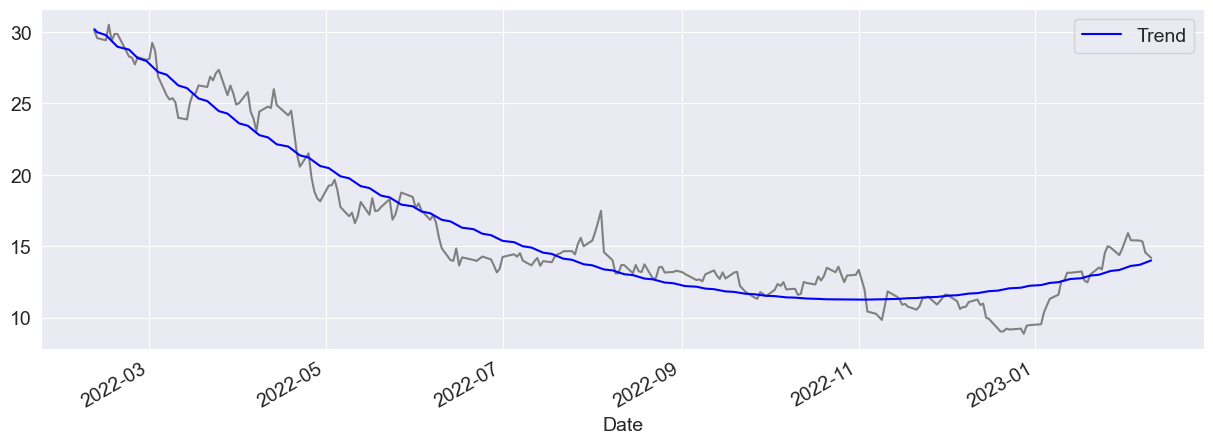

In [15]:
fig, ax = plt.subplots()

y.plot(color='grey', ax=ax)

y_pred.plot(color='blue', ax=ax);

Making forecasts.

In [16]:
X_fore = dp.out_of_sample(steps=30)
y_fore = pd.DataFrame(model.predict(X_fore), columns=['Forecasts'])

y_fore.index = pd.date_range(start='2023-01-07', periods=30)
y_fore.head()

,Forecasts
2023-01-07,14.085151
2023-01-08,14.166193
2023-01-09,14.248380
2023-01-10,14.331713
2023-01-11,14.416192


Plotting actual values, trend and forecasted trend.

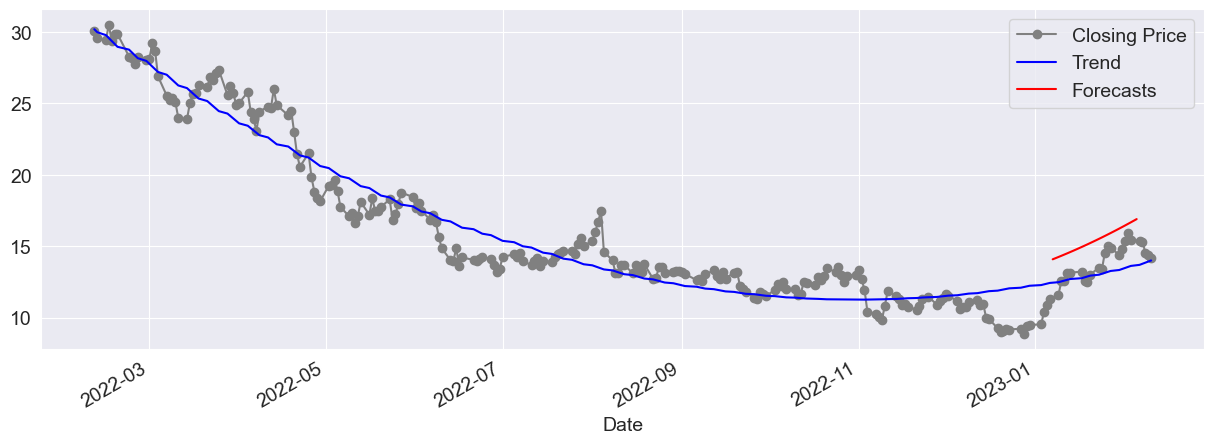

In [17]:
fig, ax = plt.subplots()

# Actual Values
warner.plot(color='grey', marker='o', ax=ax)

# Trend
y_pred.plot(color='blue', ax=ax)

# Forecasts
y_fore.plot(color='red', ax=ax);

# Hybrid Models Usage  

Firstly, series will be detrended (using LinearRegression()); then the XGBRegressor will be used on the residuals.

Splitting the X and the y on the month basis.
Data until 24-10-2022 will be included in the training set, others will be part of the test set.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Checking the sets.

In [19]:
X_train

,const,trend,trend_squared
Date,,,
2022-02-10,1.0,1.0,1.0
2022-02-11,1.0,2.0,4.0
2022-02-14,1.0,3.0,9.0
2022-02-15,1.0,4.0,16.0
2022-02-16,1.0,5.0,25.0
...,...,...,...
2022-11-21,1.0,197.0,38809.0
2022-11-22,1.0,198.0,39204.0
2022-11-23,1.0,199.0,39601.0


In [20]:
X_test.head()

,const,trend,trend_squared
Date,,,
2022-11-29,1.0,202.0,40804.0
2022-11-30,1.0,203.0,41209.0
2022-12-01,1.0,204.0,41616.0
2022-12-02,1.0,205.0,42025.0
2022-12-05,1.0,206.0,42436.0


In [21]:
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (201, 3)
X_test shape: (51, 3)


In [22]:
y_train

Date
2022-02-10    30.090000
2022-02-11    29.570000
2022-02-14    29.420000
2022-02-15    30.510000
2022-02-16    29.379999
                ...    
2022-11-21    10.560000
2022-11-22    10.800000
2022-11-23    11.340000
2022-11-25    11.470000
2022-11-28    10.920000
Name: Closing Price, Length: 201, dtype: float64

In [23]:
y_test.head()

Date
2022-11-29    11.14
2022-11-30    11.40
2022-12-01    11.63
2022-12-02    11.55
2022-12-05    11.15
Name: Closing Price, dtype: float64

Model creation.

In [24]:
# Creating the Model
lin_model = LinearRegression(fit_intercept=False)
lin_model.fit(X_train, y_train)

# Storing the Predictions (y_pred --> training set; y_fore --> test set)
y_pred = pd.DataFrame(lin_model.predict(X_train), columns=['Predictions'], index=X_train.index)
y_fore = pd.DataFrame(lin_model.predict(X_test), columns=['Forecasts'], index=X_test.index)

Plotting the results.

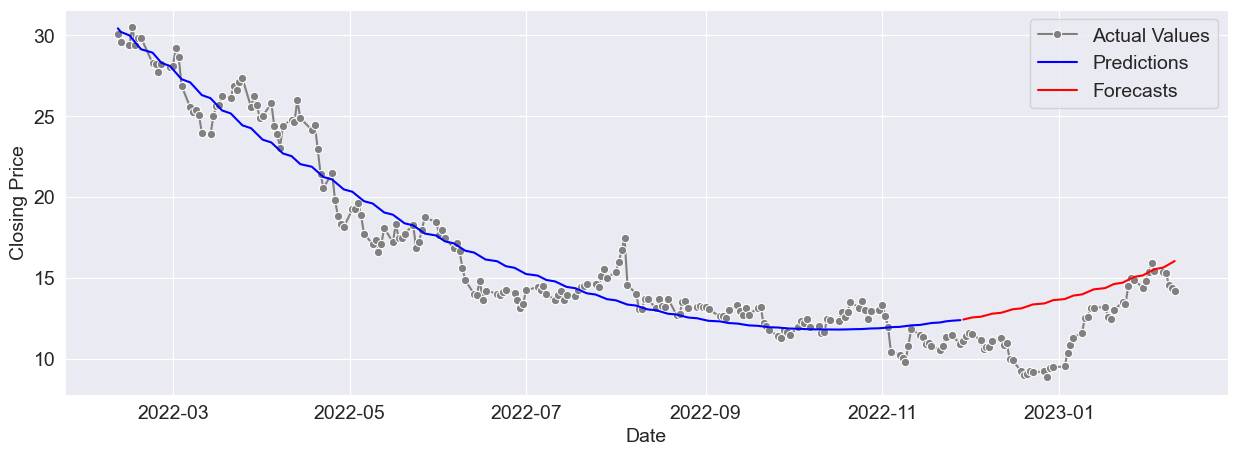

In [25]:
# Actual Values
sns.lineplot(data=warner, x=warner.index, y='Closing Price', color='grey', marker='o')

# Predictions
sns.lineplot(data=y_pred, x=y_pred.index, y='Predictions', color='blue')

# Forecasts
sns.lineplot(data=y_fore, x=y_fore.index, y='Forecasts', color='red')
plt.legend(['Actual Values', 'Predictions', 'Forecasts']);

Second part using XGBRegressor.  

Firstly, some features must be created.

In [26]:
warner['Year'] = pd.to_datetime(warner.index).year
warner['Month'] = pd.to_datetime(warner.index).month
warner['DayOfWeek'] = pd.to_datetime(warner.index).dayofweek

warner

,Closing Price,Year,Month,DayOfWeek
Date,,,,
2022-02-10,30.090000,2022,2,3
2022-02-11,29.570000,2022,2,4
2022-02-14,29.420000,2022,2,0
2022-02-15,30.510000,2022,2,1
2022-02-16,29.379999,2022,2,2
...,...,...,...,...
2023-02-06,15.400000,2023,2,0
2023-02-07,15.330000,2023,2,1
2023-02-08,14.560000,2023,2,2


Defining X and y.

In [27]:
X = warner.drop(columns='Closing Price')
y = warner['Closing Price']

In [28]:
X.head()

,Year,Month,DayOfWeek
Date,,,
2022-02-10,2022,2,3
2022-02-11,2022,2,4
2022-02-14,2022,2,0
2022-02-15,2022,2,1
2022-02-16,2022,2,2


In [29]:
y.head()

Date
2022-02-10    30.090000
2022-02-11    29.570000
2022-02-14    29.420000
2022-02-15    30.510000
2022-02-16    29.379999
Name: Closing Price, dtype: float64

Splitting.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

In [31]:
X_train

,Year,Month,DayOfWeek
Date,,,
2022-02-10,2022,2,3
2022-02-11,2022,2,4
2022-02-14,2022,2,0
2022-02-15,2022,2,1
2022-02-16,2022,2,2
...,...,...,...
2022-11-21,2022,11,0
2022-11-22,2022,11,1
2022-11-23,2022,11,2


In [32]:
X_test.head()

,Year,Month,DayOfWeek
Date,,,
2022-11-29,2022,11,1
2022-11-30,2022,11,2
2022-12-01,2022,12,3
2022-12-02,2022,12,4
2022-12-05,2022,12,0


In [33]:
y_train

Date
2022-02-10    30.090000
2022-02-11    29.570000
2022-02-14    29.420000
2022-02-15    30.510000
2022-02-16    29.379999
                ...    
2022-11-21    10.560000
2022-11-22    10.800000
2022-11-23    11.340000
2022-11-25    11.470000
2022-11-28    10.920000
Name: Closing Price, Length: 201, dtype: float64

In [34]:
y_test.head()

Date
2022-11-29    11.14
2022-11-30    11.40
2022-12-01    11.63
2022-12-02    11.55
2022-12-05    11.15
Name: Closing Price, dtype: float64

Creating the residuals.

In [35]:
y_resid = y_train - y_pred.squeeze()
y_resid

Date
2022-02-10   -0.349491
2022-02-11   -0.650979
2022-02-14   -0.583756
2022-02-15    0.722178
2022-02-16   -0.193180
                ...   
2022-11-21   -1.695298
2022-11-22   -1.489547
2022-11-23   -0.985086
2022-11-25   -0.891914
2022-11-28   -1.480032
Length: 201, dtype: float64

Creating the model to fit with the residuals.

In [36]:
from xgboost import XGBRegressor

# Creating the Model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_resid)

# Adding the predicted residuals to the trend
y_pred_xgb = xgb_model.predict(X_train) + y_pred.squeeze()
y_fore_xgb = xgb_model.predict(X_test) + y_fore.squeeze()

In [37]:
y_pred_xgb

Date
2022-02-10    30.229032
2022-02-11    30.217089
2022-02-14    29.684373
2022-02-15    29.819008
2022-02-16    29.221740
                ...    
2022-11-21    10.879844
2022-11-22    11.590556
2022-11-23    11.407778
2022-11-25    11.333757
2022-11-28    11.024578
Name: Predictions, Length: 201, dtype: float64

In [38]:
y_fore_xgb.head()

Date
2022-11-29    11.740449
2022-11-30    11.562829
2022-12-01    11.702135
2022-12-02    11.537242
2022-12-05    11.234512
Name: Forecasts, dtype: float64

Plotting the results.

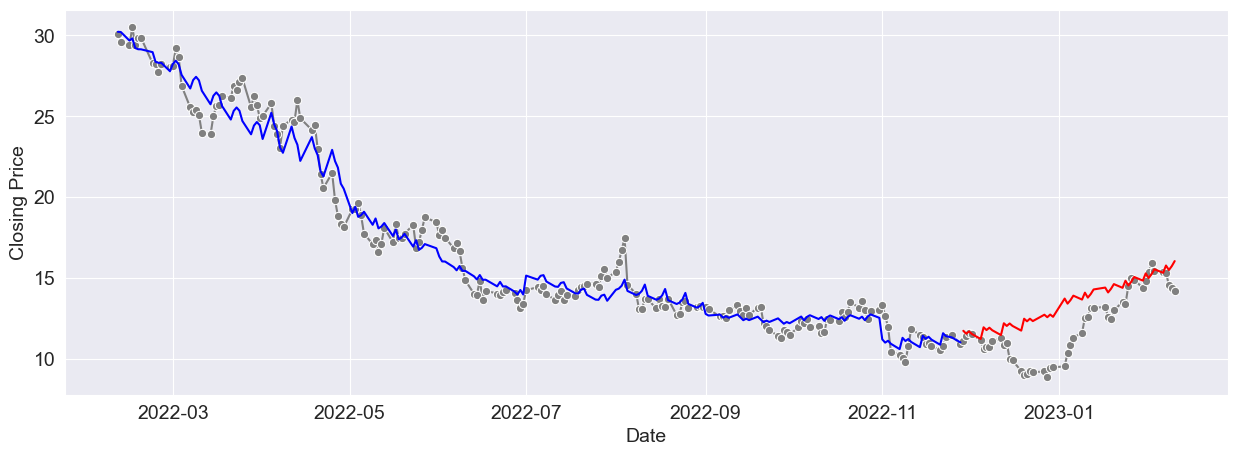

In [39]:
# Actual Values
sns.lineplot(data=warner, x=warner.index, y='Closing Price', marker='o', color='grey')

# Predictions
sns.lineplot(data=y_pred_xgb, x=y_pred_xgb.index, y=y_pred_xgb.values, color='blue')

# Forecasts
sns.lineplot(data=y_fore_xgb, x=y_fore_xgb.index, y=y_fore_xgb.values, color='red');

# Forecasts  

It will be performed some forecasts on a 4-day horizon with 1-day lead time. 

Creation of the lags.

In [40]:
warner.drop(columns=['Year', 'Month', 'DayOfWeek'], inplace=True)
warner

,Closing Price
Date,
2022-02-10,30.090000
2022-02-11,29.570000
2022-02-14,29.420000
2022-02-15,30.510000
2022-02-16,29.379999
...,...
2023-02-06,15.400000
2023-02-07,15.330000
2023-02-08,14.560000


In [41]:
def lag_creation(period):
    new_col = warner['Closing Price'].shift(period)
    warner['Lag_{}'.format(period)] = new_col

In [42]:
[lag_creation(period) for period in range(1,5)]
warner

,Closing Price,Lag_1,Lag_2,Lag_3,Lag_4
Date,,,,,
2022-02-10,30.090000,NaN,NaN,NaN,NaN
2022-02-11,29.570000,30.09,NaN,NaN,NaN
2022-02-14,29.420000,29.57,30.09,NaN,NaN
2022-02-15,30.510000,29.42,29.57,30.09,NaN
2022-02-16,29.379999,30.51,29.42,29.57,30.09
...,...,...,...,...,...
2023-02-06,15.400000,15.42,15.92,15.36,14.82
2023-02-07,15.330000,15.40,15.42,15.92,15.36
2023-02-08,14.560000,15.33,15.40,15.42,15.92


In [43]:
warner.fillna(0, inplace=True)
warner

,Closing Price,Lag_1,Lag_2,Lag_3,Lag_4
Date,,,,,
2022-02-10,30.090000,0.00,0.00,0.00,0.00
2022-02-11,29.570000,30.09,0.00,0.00,0.00
2022-02-14,29.420000,29.57,30.09,0.00,0.00
2022-02-15,30.510000,29.42,29.57,30.09,0.00
2022-02-16,29.379999,30.51,29.42,29.57,30.09
...,...,...,...,...,...
2023-02-06,15.400000,15.42,15.92,15.36,14.82
2023-02-07,15.330000,15.40,15.42,15.92,15.36
2023-02-08,14.560000,15.33,15.40,15.42,15.92


Creating the X.

In [44]:
X = warner.drop(columns='Closing Price')
X

,Lag_1,Lag_2,Lag_3,Lag_4
Date,,,,
2022-02-10,0.00,0.00,0.00,0.00
2022-02-11,30.09,0.00,0.00,0.00
2022-02-14,29.57,30.09,0.00,0.00
2022-02-15,29.42,29.57,30.09,0.00
2022-02-16,30.51,29.42,29.57,30.09
...,...,...,...,...
2023-02-06,15.42,15.92,15.36,14.82
2023-02-07,15.40,15.42,15.92,15.36
2023-02-08,15.33,15.40,15.42,15.92


Creating 4 steps.

In [45]:
def step_creator(step):
    new_col = warner['Closing Price'].shift(-step)
    warner['Step_{}'.format(step)] = new_col

In [46]:
[step_creator(step) for step in range(4)]
warner

,Closing Price,Lag_1,Lag_2,Lag_3,Lag_4,Step_0,Step_1,Step_2,Step_3
Date,,,,,,,,,
2022-02-10,30.090000,0.00,0.00,0.00,0.00,30.090000,29.570000,29.420000,30.510000
2022-02-11,29.570000,30.09,0.00,0.00,0.00,29.570000,29.420000,30.510000,29.379999
2022-02-14,29.420000,29.57,30.09,0.00,0.00,29.420000,30.510000,29.379999,29.870001
2022-02-15,30.510000,29.42,29.57,30.09,0.00,30.510000,29.379999,29.870001,29.860001
2022-02-16,29.379999,30.51,29.42,29.57,30.09,29.379999,29.870001,29.860001,28.280001
...,...,...,...,...,...,...,...,...,...
2023-02-06,15.400000,15.42,15.92,15.36,14.82,15.400000,15.330000,14.560000,14.370000
2023-02-07,15.330000,15.40,15.42,15.92,15.36,15.330000,14.560000,14.370000,14.190000
2023-02-08,14.560000,15.33,15.40,15.42,15.92,14.560000,14.370000,14.190000,NaN


Step_0 and Closing Price are the same.

Choosing the y.

In [47]:
y = warner.drop(columns=warner.columns[:5])
y.dropna(inplace=True)
y

,Step_0,Step_1,Step_2,Step_3
Date,,,,
2022-02-10,30.090000,29.570000,29.420000,30.510000
2022-02-11,29.570000,29.420000,30.510000,29.379999
2022-02-14,29.420000,30.510000,29.379999,29.870001
2022-02-15,30.510000,29.379999,29.870001,29.860001
2022-02-16,29.379999,29.870001,29.860001,28.280001
...,...,...,...,...
2023-02-01,15.360000,15.920000,15.420000,15.400000
2023-02-02,15.920000,15.420000,15.400000,15.330000
2023-02-03,15.420000,15.400000,15.330000,14.560000


Since X and y have different shapes, only the periods in both dataset will be selected.

In [48]:
final_df = pd.concat([y,X], axis=1).dropna()
final_df

,Step_0,Step_1,Step_2,Step_3,Lag_1,Lag_2,Lag_3,Lag_4
Date,,,,,,,,
2022-02-10,30.090000,29.570000,29.420000,30.510000,0.00,0.00,0.00,0.00
2022-02-11,29.570000,29.420000,30.510000,29.379999,30.09,0.00,0.00,0.00
2022-02-14,29.420000,30.510000,29.379999,29.870001,29.57,30.09,0.00,0.00
2022-02-15,30.510000,29.379999,29.870001,29.860001,29.42,29.57,30.09,0.00
2022-02-16,29.379999,29.870001,29.860001,28.280001,30.51,29.42,29.57,30.09
...,...,...,...,...,...,...,...,...
2023-02-01,15.360000,15.920000,15.420000,15.400000,14.82,14.38,14.91,15.00
2023-02-02,15.920000,15.420000,15.400000,15.330000,15.36,14.82,14.38,14.91
2023-02-03,15.420000,15.400000,15.330000,14.560000,15.92,15.36,14.82,14.38


Creating the new X and the new y.

In [49]:
X = final_df.drop(columns=final_df.columns[:4])
y = final_df.drop(columns=final_df.columns[4:])

In [50]:
X

,Lag_1,Lag_2,Lag_3,Lag_4
Date,,,,
2022-02-10,0.00,0.00,0.00,0.00
2022-02-11,30.09,0.00,0.00,0.00
2022-02-14,29.57,30.09,0.00,0.00
2022-02-15,29.42,29.57,30.09,0.00
2022-02-16,30.51,29.42,29.57,30.09
...,...,...,...,...
2023-02-01,14.82,14.38,14.91,15.00
2023-02-02,15.36,14.82,14.38,14.91
2023-02-03,15.92,15.36,14.82,14.38


In [51]:
y

,Step_0,Step_1,Step_2,Step_3
Date,,,,
2022-02-10,30.090000,29.570000,29.420000,30.510000
2022-02-11,29.570000,29.420000,30.510000,29.379999
2022-02-14,29.420000,30.510000,29.379999,29.870001
2022-02-15,30.510000,29.379999,29.870001,29.860001
2022-02-16,29.379999,29.870001,29.860001,28.280001
...,...,...,...,...
2023-02-01,15.360000,15.920000,15.420000,15.400000
2023-02-02,15.920000,15.420000,15.400000,15.330000
2023-02-03,15.420000,15.400000,15.330000,14.560000


## MultiOutput Strategy  

It will be used the LinearRegression() algorithm.

In [52]:
# Splitting X and y
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

# Creating the Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Storing the Results
y_pred = pd.DataFrame(linear_model.predict(X_train), index=y_train.index, columns=y.columns)
y_fore = pd.DataFrame(linear_model.predict(X_test), index=y_test.index, columns=y.columns)

In [53]:
y_pred

,Step_0,Step_1,Step_2,Step_3
Date,,,,
2022-02-10,1.741036,1.898933,2.071139,2.321049
2022-02-11,29.517837,29.194284,30.242874,28.855769
2022-02-14,29.228310,30.278645,28.890470,29.277770
2022-02-15,30.436165,29.035139,29.426865,29.364897
2022-02-16,29.224078,28.945034,28.683549,28.279512
...,...,...,...,...
2022-11-17,11.536088,11.540141,11.521204,11.561149
2022-11-18,11.597930,11.582199,11.597012,11.615411
2022-11-21,11.415681,11.433309,11.417789,11.456886


In [54]:
y_train

,Step_0,Step_1,Step_2,Step_3
Date,,,,
2022-02-10,30.090000,29.570000,29.420000,30.510000
2022-02-11,29.570000,29.420000,30.510000,29.379999
2022-02-14,29.420000,30.510000,29.379999,29.870001
2022-02-15,30.510000,29.379999,29.870001,29.860001
2022-02-16,29.379999,29.870001,29.860001,28.280001
...,...,...,...,...
2022-11-17,10.960000,10.770000,10.560000,10.800000
2022-11-18,10.770000,10.560000,10.800000,11.340000
2022-11-21,10.560000,10.800000,11.340000,11.470000


In [55]:
y_fore.head()

,Step_0,Step_1,Step_2,Step_3
Date,,,,
2022-11-25,11.965983,11.974946,11.981048,11.990058
2022-11-28,12.115485,12.119784,12.104767,12.136597
2022-11-29,11.615310,11.599505,11.583957,11.643340
2022-11-30,11.781372,11.746404,11.777086,11.785688
2022-12-01,11.988629,12.008675,11.994494,12.008311


Plotting the results.

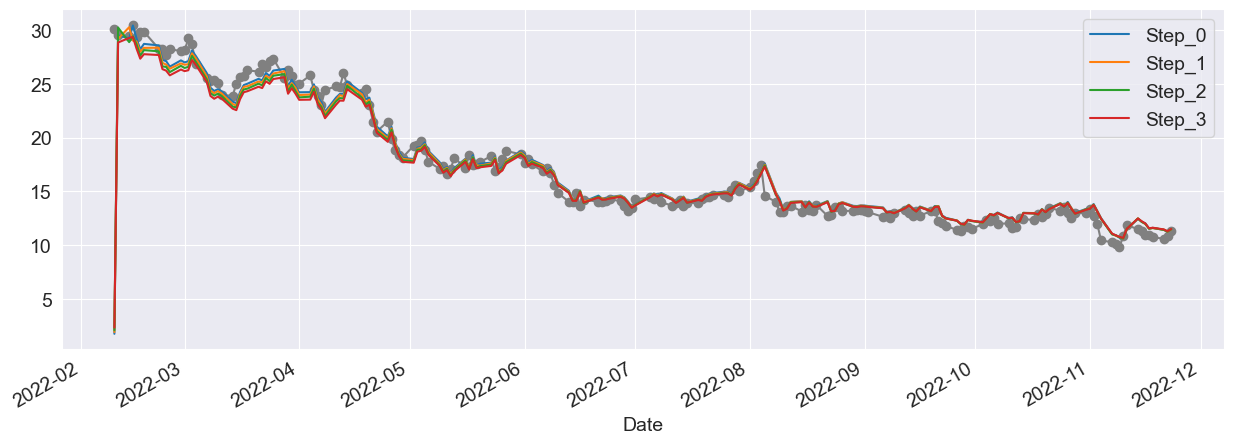

In [56]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_pred.index].plot(color='grey', marker='o')

# y_pred
y_pred.plot(ax=ax);

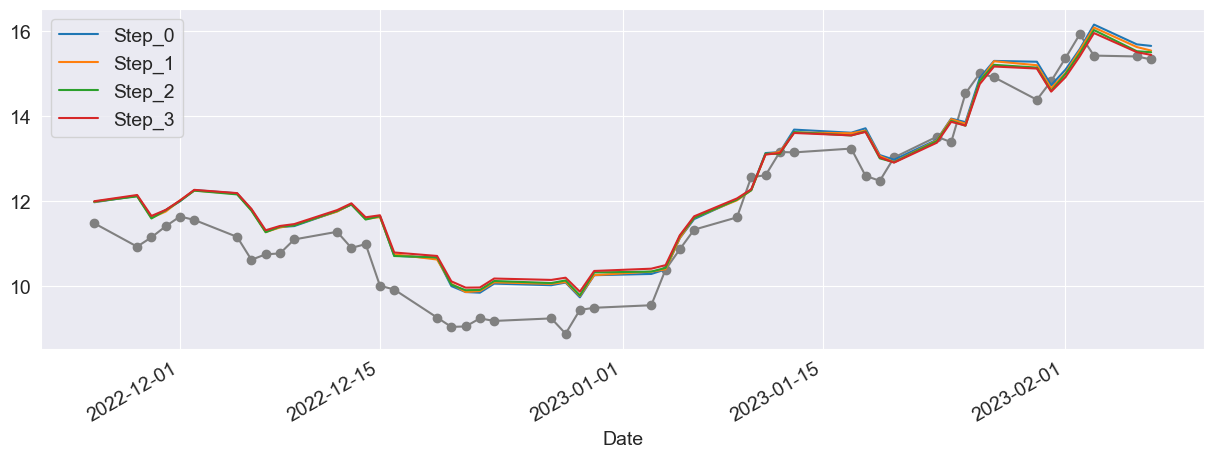

In [57]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_fore.index].plot(color='grey', marker='o')

# y_pred
y_fore.plot(ax=ax);

Checking the RMSE.

In [58]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_train, y_pred, squared=False))
print(mean_squared_error(y_test, y_fore, squared=False))

2.2559065031809293
0.8898492282297625


The RMSE is quite good. The biggest mistake was done on the first observation.

## Direct Strategy  

Direct Strategy with XGBRegressor.

In [59]:
from sklearn.multioutput import MultiOutputRegressor

xgb_multi = MultiOutputRegressor(XGBRegressor())
xgb_multi.fit(X_train, y_train)

y_pred = pd.DataFrame(xgb_multi.predict(X_train), index=X_train.index, columns=y.columns)
y_fore = pd.DataFrame(xgb_multi.predict(X_test), index=X_test.index, columns=y.columns)

Plotting the results.

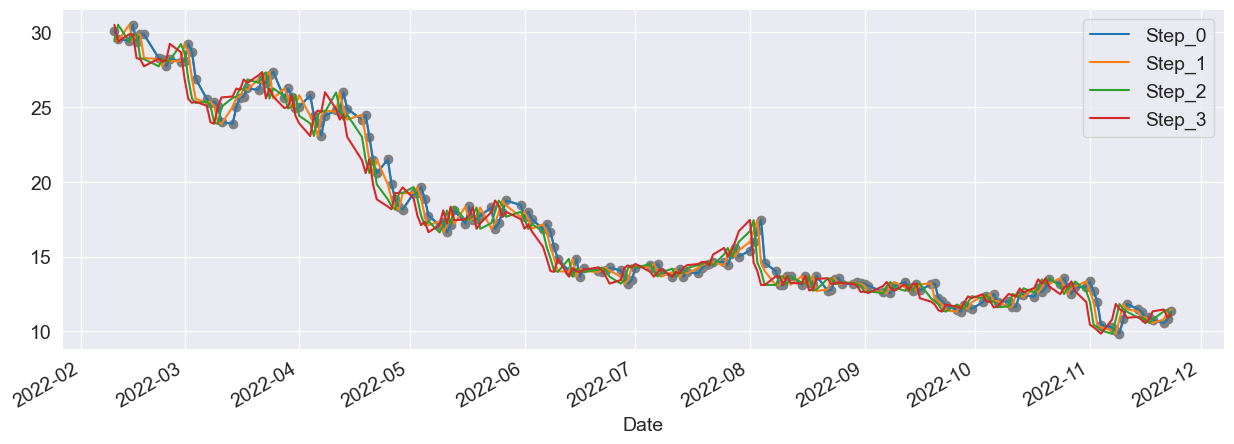

In [60]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_pred.index].plot(color='grey', marker='o', ax=ax)

# Predictions
y_pred.plot(ax=ax);


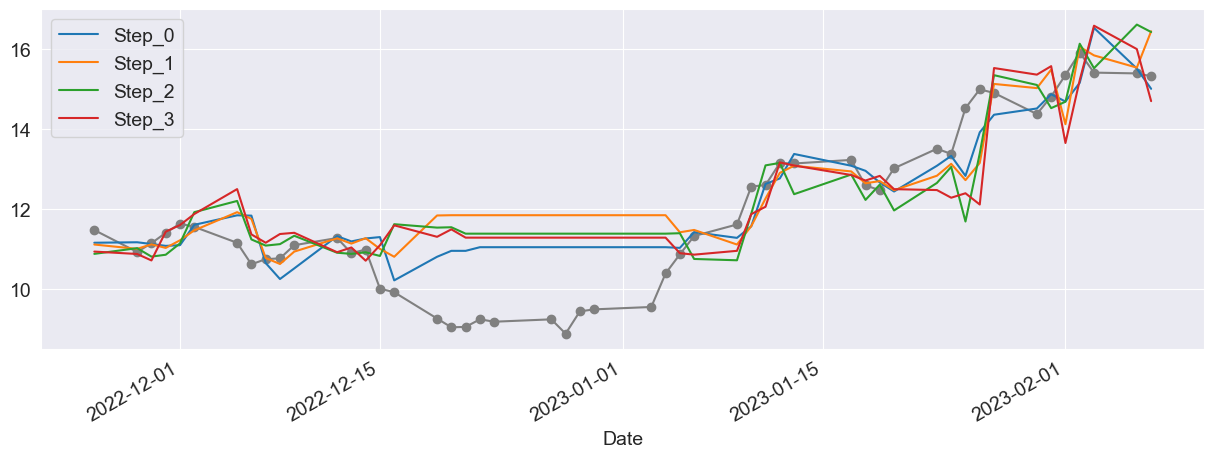

In [61]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_fore.index].plot(color='grey', marker='o', ax=ax)

# Forecasts
y_fore.plot(ax=ax);

It seems to show overfitting.

In [62]:
print(mean_squared_error(y_train, y_pred, squared=False))
print(mean_squared_error(y_test, y_fore, squared=False))

0.009888430838807095
1.3084620784637246
